# 07 - Real-World Example: E-Commerce Order Processing

This capstone notebook demonstrates a complete, production-style pipeline that combines everything we've learned. We'll build a modular order processing system using **pipeline compounding** - composing smaller pipelines into larger ones.

| Part | Topic |
|------|-------|
| **1** | The Business Problem |
| **2** | Building Reusable Pipeline Components |
| **3** | Pipeline Compounding |
| **4** | The Complete Pipeline |
| **5** | Running & Debugging |

In [1]:
import polars as pl

from nebula import TransformerPipeline
from nebula import nebula_storage as ns
from nebula.transformers import (
    AddLiterals,
    Cast,
    DropColumns,
    DropNulls,
    Filter,
    GroupBy,
    MathOperator,
    RenameColumns,
    SelectColumns,
    When,
)

---
## Part 1: The Business Problem

We're building an order processing pipeline for an e-commerce company that needs to:

1. **Clean** raw order data (handle nulls, validate)
2. **Enrich** with customer tiers and regional tax rates
3. **Calculate** final amounts with discounts and taxes
4. **Route** orders differently based on value (high-value get priority handling)
5. **Aggregate** metrics for reporting

### 1.1 Sample Data

In [2]:
# Raw orders from the web store
raw_orders = pl.DataFrame({
    "order_id": [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008],
    "customer_id": ["C001", "C002", "C001", "C003", "C002", "C004", None, "C001"],
    "product": ["Laptop", "Mouse", "Keyboard", "Monitor", "Laptop", "Mouse", "Cable", "Laptop"],
    "quantity": [1, 2, 1, 1, 1, 5, 3, 2],
    "unit_price": [999.99, 29.99, 79.99, 299.99, 999.99, 29.99, 9.99, 999.99],
    "region": ["US", "EU", "US", "APAC", "EU", "US", "US", "US"],
})

# Customer tier data (from CRM system)
customer_tiers = pl.DataFrame({
    "customer_id": ["C001", "C002", "C003", "C004"],
    "tier": ["gold", "silver", "bronze", "silver"],
    "discount_rate": [0.15, 0.10, 0.05, 0.10],
})

print("Raw Orders:")
print(raw_orders)
print("\nCustomer Tiers:")
print(customer_tiers)

Raw Orders:
shape: (8, 6)
┌──────────┬─────────────┬──────────┬──────────┬────────────┬────────┐
│ order_id ┆ customer_id ┆ product  ┆ quantity ┆ unit_price ┆ region │
│ ---      ┆ ---         ┆ ---      ┆ ---      ┆ ---        ┆ ---    │
│ i64      ┆ str         ┆ str      ┆ i64      ┆ f64        ┆ str    │
╞══════════╪═════════════╪══════════╪══════════╪════════════╪════════╡
│ 1001     ┆ C001        ┆ Laptop   ┆ 1        ┆ 999.99     ┆ US     │
│ 1002     ┆ C002        ┆ Mouse    ┆ 2        ┆ 29.99      ┆ EU     │
│ 1003     ┆ C001        ┆ Keyboard ┆ 1        ┆ 79.99      ┆ US     │
│ 1004     ┆ C003        ┆ Monitor  ┆ 1        ┆ 299.99     ┆ APAC   │
│ 1005     ┆ C002        ┆ Laptop   ┆ 1        ┆ 999.99     ┆ EU     │
│ 1006     ┆ C004        ┆ Mouse    ┆ 5        ┆ 29.99      ┆ US     │
│ 1007     ┆ null        ┆ Cable    ┆ 3        ┆ 9.99       ┆ US     │
│ 1008     ┆ C001        ┆ Laptop   ┆ 2        ┆ 999.99     ┆ US     │
└──────────┴─────────────┴──────────┴──────────┴───

---
## Part 2: Building Reusable Pipeline Components

Instead of one monolithic pipeline, we'll build small, focused components that can be tested independently and reused.

### 2.1 Data Cleaning Pipeline

In [3]:
cleaning_pipeline = TransformerPipeline(
    [
        # Remove orders with missing customer
        DropNulls(columns=["customer_id"]),
        
        # Ensure numeric types
        Cast(cast={
            "quantity": "int64",
            "unit_price": "float64",
        }),
        
        (
            Filter(input_col="quantity", perform="keep", operator="gt", value=0),
            "Filter out invalid quantities"
        ),
    ],
    name="Data Cleaning",
)

# Test it independently
cleaning_pipeline.show()
cleaned = cleaning_pipeline.run(raw_orders)
print(f"\nRows: {len(raw_orders)} → {len(cleaned)} (removed {len(raw_orders) - len(cleaned)})")

2025-12-26 02:47:28,772 | [INFO]: Starting pipeline 'Data Cleaning' 
2025-12-26 02:47:28,772 | [INFO]: Running 'DropNulls' ... 
2025-12-26 02:47:28,772 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 02:47:28,772 | [INFO]: Running 'Cast' ... 
2025-12-26 02:47:28,788 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-26 02:47:28,789 | [INFO]: Running 'Filter' ... 
2025-12-26 02:47:28,789 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 02:47:28,791 | [INFO]: Pipeline 'Data Cleaning' completed in 0.0s 


*** Data Cleaning *** (3 transformations)
 - DropNulls
 - Cast
 - Filter
     Description: Filter out invalid quantities

Rows: 8 → 7 (removed 1)


### 2.2 Customer Enrichment Pipeline

In [4]:
# Store customer data for the branch to use
ns.clear()
ns.set("customer_tiers", customer_tiers)

enrichment_pipeline = TransformerPipeline(
    [
        # Just select the columns we need to join
        SelectColumns(columns=["customer_id", "tier", "discount_rate"]),
    ],
    name="Customer Enrichment",
    branch={
        "storage": "customer_tiers",
        "end": "join",
        "on": "customer_id",
        "how": "left",
    },
)

enrichment_pipeline.show()

2025-12-26 02:47:28,807 | [INFO]: Nebula Storage: clear. 
2025-12-26 02:47:28,808 | [INFO]: Nebula Storage: 0 keys remained after clearing. 
2025-12-26 02:47:28,808 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "customer_tiers". 


*** Customer Enrichment *** (1 transformation)
------ BRANCH (from storage: customer_tiers) ------
>> Branch (1 transformation):
     - SelectColumns
<<< Join DFs >>>


### 2.3 Amount Calculation Pipeline

In [5]:
calculation_pipeline = TransformerPipeline(
    [
        (MathOperator(strategy={
            "new_column_name": "subtotal",
            "strategy": [
                {"column": "quantity", "cast": "float64"},
                {"column": "unit_price"},
            ],
            "operations": ["mul"],
        }), "subtotal = quantity * unit_price"),
        
        (MathOperator(strategy={
            "new_column_name": "discount_amount",
            "strategy": [
                {"column": "subtotal"},
                {"column": "discount_rate"},
            ],
            "operations": ["mul"],
        }), "discount_amount = subtotal * discount_rate"),
        
        (MathOperator(strategy={
            "new_column_name": "final_amount",
            "strategy": [
                {"column": "subtotal"},
                {"column": "discount_amount"},
            ],
            "operations": ["sub"],
        }),"final_amount = subtotal - discount_amount"),
    ],
    name="Amount Calculations",
)

calculation_pipeline.show(add_params=True)

*** Amount Calculations *** (3 transformations)
 - MathOperator -> PARAMS: strategy={'new_column_name': 'subtota ... unit_price'}], 'operations': ['mul']}
     Description: subtotal = quantity * unit_price
 - MathOperator -> PARAMS: strategy={'new_column_name': 'discoun ... count_rate'}], 'operations': ['mul']}
     Description: discount_amount = subtotal * discount_rate
 - MathOperator -> PARAMS: strategy={'new_column_name': 'final_a ... unt_amount'}], 'operations': ['sub']}
     Description: final_amount = subtotal - discount_amount


### 2.4 Priority Assignment Pipeline

In [6]:
priority_pipeline = TransformerPipeline(
    [
        (When(
            output_col="priority",
            conditions=[
                # Gold customers or high-value orders get priority
                {"input_col": "tier", "operator": "eq", "value": "gold",
                 "output_constant": "high"},
                {"input_col": "final_amount", "operator": "ge", "value": 500,
                 "output_constant": "high"},
                {"input_col": "final_amount", "operator": "ge", "value": 100,
                 "output_constant": "medium"},
            ],
            otherwise_constant="standard",
        ), "Gold customers or high-value orders get priority"),
    ],
    name="Priority Assignment",
)

priority_pipeline.show(add_params=True)

*** Priority Assignment *** (1 transformation)
 - When -> PARAMS: conditions=[{'input_col': 'tier', 'op ... ant="standard", output_col="priority"
     Description: Gold customers or high-value orders get priority


---
## Part 3: Pipeline Compounding

**Pipeline compounding** means using `TransformerPipeline` instances as steps inside other pipelines. This creates a hierarchical, modular structure.

### 3.1 Basic Compounding

In [7]:
# Compose pipelines together
order_processing = TransformerPipeline(
    [
        cleaning_pipeline,      # ← Entire pipeline as a step
        enrichment_pipeline,    # ← Another pipeline
        calculation_pipeline,   # ← And another
        priority_pipeline,      # ← And another
    ],
    name="Order Processing (Composed)",
)

order_processing.show()

*** Order Processing (Composed) *** (8 transformations)
*** Data Cleaning *** (3 transformations)
 - DropNulls
 - Cast
 - Filter
     Description: Filter out invalid quantities
*** Customer Enrichment *** (1 transformation)
------ BRANCH (from storage: customer_tiers) ------
>> Branch (1 transformation):
     - SelectColumns
<<< Join DFs >>>
*** Amount Calculations *** (3 transformations)
 - MathOperator
     Description: subtotal = quantity * unit_price
 - MathOperator
     Description: discount_amount = subtotal * discount_rate
 - MathOperator
     Description: final_amount = subtotal - discount_amount
 - When
     Description: Gold customers or high-value orders get priority


In [8]:
result = order_processing.run(raw_orders)
print(result)

2025-12-26 02:47:28,856 | [INFO]: Starting pipeline 'Order Processing (Composed)' 
2025-12-26 02:47:28,857 | [INFO]: Running 'DropNulls' ... 
2025-12-26 02:47:28,858 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Running 'Cast' ... 
2025-12-26 02:47:28,860 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Running 'Filter' ... 
2025-12-26 02:47:28,860 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Entering branch 
2025-12-26 02:47:28,860 | [INFO]: Running 'SelectColumns' ... 
2025-12-26 02:47:28,860 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,860 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,860 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 02:47:28,860 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,871 | [INFO]: Completed 'MathOperato

shape: (7, 12)
┌──────────┬─────────────┬──────────┬──────────┬───┬──────────┬─────────────────┬──────────────┬──────────┐
│ order_id ┆ customer_id ┆ product  ┆ quantity ┆ … ┆ subtotal ┆ discount_amount ┆ final_amount ┆ priority │
│ ---      ┆ ---         ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---             ┆ ---          ┆ ---      │
│ i64      ┆ str         ┆ str      ┆ i64      ┆   ┆ f64      ┆ f64             ┆ f64          ┆ str      │
╞══════════╪═════════════╪══════════╪══════════╪═══╪══════════╪═════════════════╪══════════════╪══════════╡
│ 1001     ┆ C001        ┆ Laptop   ┆ 1        ┆ … ┆ 999.99   ┆ 149.9985        ┆ 849.9915     ┆ high     │
│ 1002     ┆ C002        ┆ Mouse    ┆ 2        ┆ … ┆ 59.98    ┆ 5.998           ┆ 53.982       ┆ standard │
│ 1003     ┆ C001        ┆ Keyboard ┆ 1        ┆ … ┆ 79.99    ┆ 11.9985         ┆ 67.9915      ┆ high     │
│ 1004     ┆ C003        ┆ Monitor  ┆ 1        ┆ … ┆ 299.99   ┆ 14.9995         ┆ 284.9905     ┆ medium   │
│ 1005     ┆ 

### 3.2 Mixing Pipelines and Transformers

You can freely mix pipeline components with individual transformers:

In [9]:
final_pipeline = TransformerPipeline(
    [
        cleaning_pipeline,        # Reusable component
        enrichment_pipeline,      # Reusable component
        calculation_pipeline,     # Reusable component
        
        # Individual transformer for this specific use case
        Filter(input_col="final_amount", perform="keep", operator="ge", value=50),
        
        priority_pipeline,        # Reusable component
        
        # More individual transformers
        SelectColumns(columns=[
            "order_id", "customer_id", "product", 
            "final_amount", "tier", "priority"
        ]),
        
        {"store": "processed_orders"},  # Storage keyword
    ],
    name="Final Order Pipeline",
)

final_pipeline.show()

*** Final Order Pipeline *** (10 transformations)
*** Data Cleaning *** (3 transformations)
 - DropNulls
 - Cast
 - Filter
     Description: Filter out invalid quantities
*** Customer Enrichment *** (1 transformation)
------ BRANCH (from storage: customer_tiers) ------
>> Branch (1 transformation):
     - SelectColumns
<<< Join DFs >>>
*** Amount Calculations *** (3 transformations)
 - MathOperator
     Description: subtotal = quantity * unit_price
 - MathOperator
     Description: discount_amount = subtotal * discount_rate
 - MathOperator
     Description: final_amount = subtotal - discount_amount
 - Filter
 - When
     Description: Gold customers or high-value orders get priority
 - SelectColumns
   --> Store df with key "processed_orders"


---
## Part 4: The Complete Pipeline

Now let's build a more realistic pipeline that includes regional processing with splits.

### 4.1 Regional Tax Rates

In [10]:
def split_by_region(df):
    """Split orders by region for tax calculation."""
    return {
        "us": df.filter(pl.col("region") == "US"),
        "eu": df.filter(pl.col("region") == "EU"),
        "apac": df.filter(pl.col("region") == "APAC"),
    }

In [11]:
def make_tax_transformer(rate: float):
    """Factory function to create tax calculation pipeline."""
    return [
        AddLiterals(data=[{"alias": "tax_rate", "value": rate}]),
        MathOperator(strategy={
            "new_column_name": "tax_amount",
            "strategy": [
                {"column": "final_amount"},
                {"column": "tax_rate"},
            ],
            "operations": ["mul"],
        }),
        MathOperator(strategy={
            "new_column_name": "total_with_tax",
            "strategy": [
                {"column": "final_amount"},
                {"column": "tax_amount"},
            ],
            "operations": ["add"],
        }),
    ]


regional_tax_pipeline = TransformerPipeline(
    {
        "us": make_tax_transformer(0.08),    # 8% US tax
        "eu": make_tax_transformer(0.20),    # 20% EU VAT
        "apac": make_tax_transformer(0.10),  # 10% APAC tax
    },
    split_function=split_by_region,
    name="Regional Tax Calculation",
)

regional_tax_pipeline.show(add_params=True)

*** Regional Tax Calculation *** (9 transformations)
------ SPLIT ------ (function: split_by_region)
**SPLIT <<< apac >>> (3 transformations):
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.1}]
     - MathOperator -> PARAMS: strategy={'new_column_name': 'tax_amo ...  'tax_rate'}], 'operations': ['mul']}
     - MathOperator -> PARAMS: strategy={'new_column_name': 'total_w ... tax_amount'}], 'operations': ['add']}
**SPLIT <<< eu >>> (3 transformations):
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.2}]
     - MathOperator -> PARAMS: strategy={'new_column_name': 'tax_amo ...  'tax_rate'}], 'operations': ['mul']}
     - MathOperator -> PARAMS: strategy={'new_column_name': 'total_w ... tax_amount'}], 'operations': ['add']}
**SPLIT <<< us >>> (3 transformations):
     - AddLiterals -> PARAMS: data=[{'alias': 'tax_rate', 'value': 0.08}]
     - MathOperator -> PARAMS: strategy={'new_column_name': 'tax_amo ...  'tax_rate'}], 'operations': ['mul']}
  

### 4.2 Complete Composed Pipeline

In [12]:
complete_pipeline = TransformerPipeline(
    [
        # Stage 1: Clean
        cleaning_pipeline,
        
        # Stage 2: Enrich with customer data
        enrichment_pipeline,
        
        # Stage 3: Calculate amounts
        calculation_pipeline,

        {"store_debug": "df-before-split"},  # for debugging
        
        # Stage 4: Apply regional taxes (split pipeline)
        regional_tax_pipeline,
        
        # Stage 5: Assign priority
        priority_pipeline,
        
        # Stage 6: Final selection
        SelectColumns(columns=[
            "order_id", "customer_id", "product", "region",
            "tier", "subtotal", "discount_amount", "final_amount",
            "tax_rate", "tax_amount", "total_with_tax", "priority"
        ]),
    ],
    name="Complete Order Processing",
)

complete_pipeline.show()

*** Complete Order Processing *** (18 transformations)
*** Data Cleaning *** (3 transformations)
 - DropNulls
 - Cast
 - Filter
     Description: Filter out invalid quantities
*** Customer Enrichment *** (1 transformation)
------ BRANCH (from storage: customer_tiers) ------
>> Branch (1 transformation):
     - SelectColumns
<<< Join DFs >>>
*** Amount Calculations *** (3 transformations)
 - MathOperator
     Description: subtotal = quantity * unit_price
 - MathOperator
     Description: discount_amount = subtotal * discount_rate
 - MathOperator
     Description: final_amount = subtotal - discount_amount
   --> Store df (debug) with key "df-before-split"
*** Regional Tax Calculation *** (9 transformations)
------ SPLIT ------ (function: split_by_region)
**SPLIT <<< apac >>> (3 transformations):
     - AddLiterals
     - MathOperator
     - MathOperator
**SPLIT <<< eu >>> (3 transformations):
     - AddLiterals
     - MathOperator
     - MathOperator
**SPLIT <<< us >>> (3 transformations

In [13]:
final_result = complete_pipeline.run(raw_orders)
print(final_result)

2025-12-26 02:47:28,942 | [INFO]: Starting pipeline 'Complete Order Processing' 
2025-12-26 02:47:28,942 | [INFO]: Running 'DropNulls' ... 
2025-12-26 02:47:28,942 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 02:47:28,942 | [INFO]: Running 'Cast' ... 
2025-12-26 02:47:28,942 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-26 02:47:28,942 | [INFO]: Running 'Filter' ... 
2025-12-26 02:47:28,942 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 02:47:28,942 | [INFO]: Entering branch 
2025-12-26 02:47:28,942 | [INFO]: Running 'SelectColumns' ... 
2025-12-26 02:47:28,942 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-26 02:47:28,942 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,955 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 02:47:28,955 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,956 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 02:47:28,957 | [INFO]: Running 'MathOperator' ... 
2025-12-26 02:47:28,958 | [INFO]: Completed 'MathOperator'

shape: (7, 12)
┌──────────┬─────────────┬──────────┬────────┬───┬──────────┬────────────┬────────────────┬──────────┐
│ order_id ┆ customer_id ┆ product  ┆ region ┆ … ┆ tax_rate ┆ tax_amount ┆ total_with_tax ┆ priority │
│ ---      ┆ ---         ┆ ---      ┆ ---    ┆   ┆ ---      ┆ ---        ┆ ---            ┆ ---      │
│ i64      ┆ str         ┆ str      ┆ str    ┆   ┆ f64      ┆ f64        ┆ f64            ┆ str      │
╞══════════╪═════════════╪══════════╪════════╪═══╪══════════╪════════════╪════════════════╪══════════╡
│ 1004     ┆ C003        ┆ Monitor  ┆ APAC   ┆ … ┆ 0.1      ┆ 28.49905   ┆ 313.48955      ┆ medium   │
│ 1002     ┆ C002        ┆ Mouse    ┆ EU     ┆ … ┆ 0.2      ┆ 10.7964    ┆ 64.7784        ┆ standard │
│ 1005     ┆ C002        ┆ Laptop   ┆ EU     ┆ … ┆ 0.2      ┆ 179.9982   ┆ 1079.9892      ┆ high     │
│ 1001     ┆ C001        ┆ Laptop   ┆ US     ┆ … ┆ 0.08     ┆ 67.99932   ┆ 917.99082      ┆ high     │
│ 1003     ┆ C001        ┆ Keyboard ┆ US     ┆ … ┆ 0.08   

---
## Part 5: Running & Debugging

### 5.1 Visualize the DAG

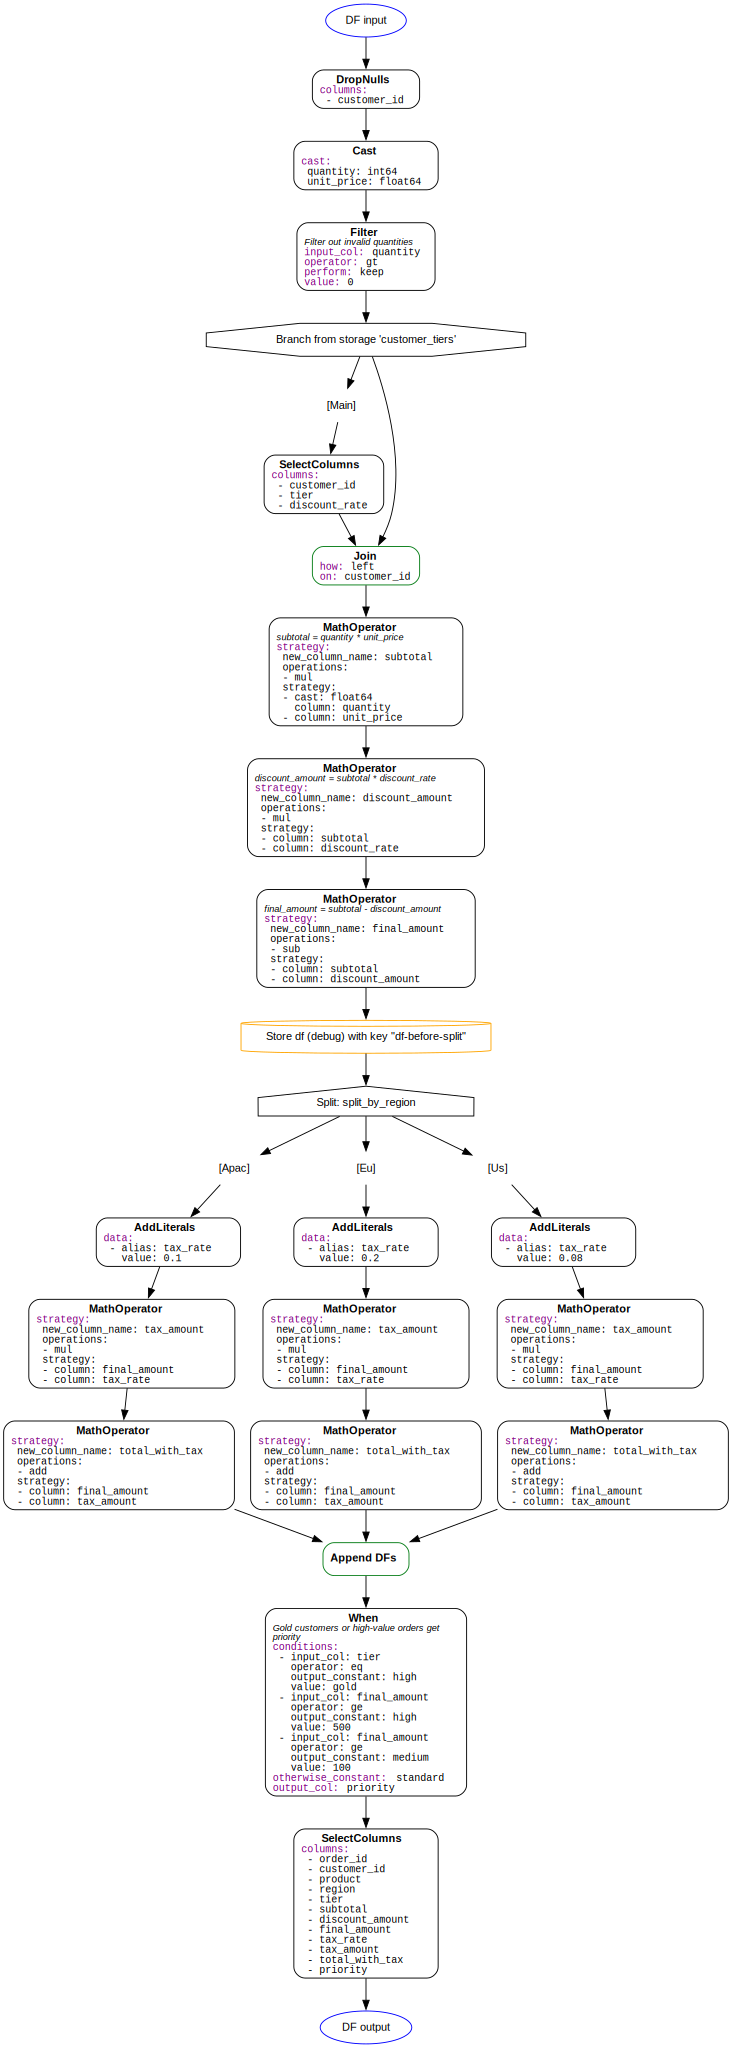

In [14]:
complete_pipeline.plot(add_params=True, add_description=True)

### 5.2 Debugging with Storage

In [15]:
ns.clear()
ns.set("customer_tiers", customer_tiers)

debug_pipeline = TransformerPipeline(
    [
        cleaning_pipeline,
        {"store": "after_cleaning"},  # Checkpoint
        
        enrichment_pipeline,
        {"store": "after_enrichment"},  # Checkpoint
        
        calculation_pipeline,
        {"store": "after_calculation"},  # Checkpoint
    ],
    name="Debug Pipeline",
)

result = debug_pipeline.run(raw_orders)

# Inspect intermediate states
print("Stored checkpoints:", ns.list_keys())
print("\nAfter enrichment:")
print(ns.get("after_enrichment"))

2025-12-26 02:47:29,234 | [INFO]: Nebula Storage: clear. 
2025-12-26 02:47:29,235 | [INFO]: Nebula Storage: 0 keys remained after clearing. 
2025-12-26 02:47:29,236 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "customer_tiers". 
2025-12-26 02:47:29,237 | [INFO]: Starting pipeline 'Debug Pipeline' 
2025-12-26 02:47:29,237 | [INFO]: Running 'DropNulls' ... 
2025-12-26 02:47:29,238 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 02:47:29,239 | [INFO]: Running 'Cast' ... 
2025-12-26 02:47:29,240 | [INFO]: Completed 'Cast' in 0.0s 
2025-12-26 02:47:29,240 | [INFO]: Running 'Filter' ... 
2025-12-26 02:47:29,242 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 02:47:29,243 | [INFO]:    --> Store df with key "after_cleaning" 
2025-12-26 02:47:29,243 | [INFO]: Nebula Storage: setting an object (<class 'polars.dataframe.frame.DataFrame'>) with the key "after_cleaning". 
2025-12-26 02:47:29,243 | [INFO]: Entering branch 
2025-12-26 02:4

Stored checkpoints: ['after_calculation', 'after_cleaning', 'after_enrichment', 'customer_tiers']

After enrichment:
shape: (7, 8)
┌──────────┬─────────────┬──────────┬──────────┬────────────┬────────┬────────┬───────────────┐
│ order_id ┆ customer_id ┆ product  ┆ quantity ┆ unit_price ┆ region ┆ tier   ┆ discount_rate │
│ ---      ┆ ---         ┆ ---      ┆ ---      ┆ ---        ┆ ---    ┆ ---    ┆ ---           │
│ i64      ┆ str         ┆ str      ┆ i64      ┆ f64        ┆ str    ┆ str    ┆ f64           │
╞══════════╪═════════════╪══════════╪══════════╪════════════╪════════╪════════╪═══════════════╡
│ 1001     ┆ C001        ┆ Laptop   ┆ 1        ┆ 999.99     ┆ US     ┆ gold   ┆ 0.15          │
│ 1002     ┆ C002        ┆ Mouse    ┆ 2        ┆ 29.99      ┆ EU     ┆ silver ┆ 0.1           │
│ 1003     ┆ C001        ┆ Keyboard ┆ 1        ┆ 79.99      ┆ US     ┆ gold   ┆ 0.15          │
│ 1004     ┆ C003        ┆ Monitor  ┆ 1        ┆ 299.99     ┆ APAC   ┆ bronze ┆ 0.05          │
│ 100

### 5.3 Reusability Patterns

**Pattern 1: Pipeline Library**
```python
# pipelines/cleaning.py
cleaning_pipeline = TransformerPipeline([...], name="Cleaning")

# pipelines/enrichment.py  
enrichment_pipeline = TransformerPipeline([...], name="Enrichment")

# main.py
from pipelines.cleaning import cleaning_pipeline
from pipelines.enrichment import enrichment_pipeline

full_pipeline = TransformerPipeline([cleaning_pipeline, enrichment_pipeline])
```

**Pattern 2: Factory Functions**
```python
def make_regional_pipeline(region: str, tax_rate: float):
    return TransformerPipeline([
        Filter(input_col="region", perform="keep", operator="eq", value=region),
        AddLiterals(data=[{"alias": "tax_rate", "value": tax_rate}]),
    ], name=f"{region} Processing")

us_pipeline = make_regional_pipeline("US", 0.08)
eu_pipeline = make_regional_pipeline("EU", 0.20)
```

**Pattern 3: Config-Driven Composition**
```python
# Load component pipelines from YAML
cleaning = load_pipeline("configs/cleaning.yaml")
enrichment = load_pipeline("configs/enrichment.yaml")

# Compose at runtime
full = TransformerPipeline([cleaning, enrichment])
```

---
## Summary

### Pipeline Compounding Benefits

| Benefit | Description |
|---------|-------------|
| **Modularity** | Small, focused components that do one thing well |
| **Testability** | Test each component independently |
| **Reusability** | Use the same cleaning pipeline across projects |
| **Readability** | High-level pipeline shows the flow; details in components |
| **Maintainability** | Change one component without affecting others |

### Key Patterns

1. **Build small, focused pipelines** - one responsibility each
2. **Compose with lists** - `[pipeline_a, pipeline_b, transformer_c]`
3. **Use factory functions** - for parameterized pipeline creation
4. **Store checkpoints** - for debugging and recovery
5. **Name your pipelines** - for clear visualization and logging

In [16]:
ns.clear()

2025-12-26 02:47:29,268 | [INFO]: Nebula Storage: clear. 
2025-12-26 02:47:29,268 | [INFO]: Nebula Storage: 0 keys remained after clearing. 
